# Лабораторная работа №4: Байесовские сети

Датасет: Mushroom Classification

Цель: построить байесовскую сеть для предсказания съедобности грибов на основе их характеристик

## 0. Установка зависимостей

In [1]:
!pip install pgmpy networkx matplotlib pandas scikit-learn kagglehub

## 1. Загрузка датасета

In [2]:
import kagglehub
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Загрузка Mushroom Classification датасета
path = Path(kagglehub.dataset_download("uciml/mushroom-classification"))
print("Path to dataset files:", path)

# Загрузка данных
file_path = path / 'mushrooms.csv'
data = pd.read_csv(file_path)

print(f"\nРазмер датасета: {data.shape}")
print(f"Количество строк: {data.shape[0]}, признаков: {data.shape[1]}")

Path to dataset files: C:\Users\shtyk\.cache\kagglehub\datasets\uciml\mushroom-classification\versions\1

Размер датасета: (8124, 23)
Количество строк: 8124, признаков: 23


In [3]:
# Просмотр структуры данных
print("Первые строки датасета:")
data.head()

Первые строки датасета:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [4]:
# Информация о датасете
print("Информация о датасете:")
data.info()

print("\nРаспределение классов:")
print(data['class'].value_counts())
print(f"\ne - edible (съедобный), p - poisonous (ядовитый)")

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  s

## 2. Обработка датасета

Для работы с pgmpy нужны дискретные данные. Применим Label Encoding для всех категориальных признаков.

In [5]:
from sklearn.preprocessing import LabelEncoder

# Создаем копию данных для обработки
data_original = data.copy()

# Применяем Label Encoding ко всем столбцам
le_dict = {}
for col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le

print("Данные после кодирования:")
data.head()

Данные после кодирования:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [6]:
# Удаляем дубликаты
print(f"Размер до удаления дубликатов: {data.shape}")
data = data.drop_duplicates()
print(f"Размер после удаления дубликатов: {data.shape}")

Размер до удаления дубликатов: (8124, 23)
Размер после удаления дубликатов: (8124, 23)


In [7]:
selected_features = ['class', 'odor', 'gill-color', 'spore-print-color', 'population', 'habitat']
data_subset = data[selected_features].copy()

print(f"Работаем с {len(selected_features)} признаками: {selected_features}")
print(f"\nРазмер данных: {data_subset.shape}")

Работаем с 6 признаками: ['class', 'odor', 'gill-color', 'spore-print-color', 'population', 'habitat']

Размер данных: (8124, 6)


## 3. Построение Байесовской сети

Построим структуру сети вручную на основе логических зависимостей:
- Запах (odor) сильно влияет на класс
- Цвет жабр (gill-color) влияет на класс
- Цвет отпечатка спор (spore-print-color) влияет на класс
- Популяция (population) и среда обитания (habitat) также влияют на класс

In [8]:
from pgmpy.models import DiscreteBayesianNetwork

network_structure = [
    ('odor', 'class'),
    ('gill-color', 'class'),
    ('spore-print-color', 'class'),
    ('population', 'class'),
    ('habitat', 'class')
]

# Создаем Байесовскую сеть
model = DiscreteBayesianNetwork(network_structure)

print("Структура сети (ребра):")
print(model.edges())

Структура сети (ребра):
[('odor', 'class'), ('gill-color', 'class'), ('spore-print-color', 'class'), ('population', 'class'), ('habitat', 'class')]


## 4. Оценка параметров модели

Используем Maximum Likelihood Estimator для оценки условных вероятностей.

In [9]:
from pgmpy.estimators import MaximumLikelihoodEstimator

# Обучаем модель на данных
model.fit(data_subset, estimator=MaximumLikelihoodEstimator)

print("Модель обучена!")
print(f"\nКоличество параметров в модели: {len(model.get_cpds())}")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'class': 'N', 'odor': 'N', 'gill-color': 'N', 'spore-print-color': 'N', 'population': 'N', 'habitat': 'N'}


Модель обучена!

Количество параметров в модели: 6


## 5. Анализ условных вероятностных таблиц (CPT)

In [10]:
# Просмотр CPT для целевой переменной (class)
print("Условные вероятности для класса (edible/poisonous):")
cpt_class = model.get_cpds('class')
print(cpt_class)

Условные вероятности для класса (edible/poisonous):
+-------------------+-----+----------------------+
| gill-color        | ... | gill-color(11)       |
+-------------------+-----+----------------------+
| habitat           | ... | habitat(6)           |
+-------------------+-----+----------------------+
| odor              | ... | odor(8)              |
+-------------------+-----+----------------------+
| population        | ... | population(5)        |
+-------------------+-----+----------------------+
| spore-print-color | ... | spore-print-color(8) |
+-------------------+-----+----------------------+
| class(0)          | ... | 0.5                  |
+-------------------+-----+----------------------+
| class(1)          | ... | 0.5                  |
+-------------------+-----+----------------------+


In [11]:
# Просмотр CPT для признака 'odor' (запах)
print("\nУсловные вероятности для признака 'odor' (запах):")
cpt_odor = model.get_cpds('odor')
print(cpt_odor)

print("\nРасшифровка значений odor:")
for idx, label in enumerate(le_dict['odor'].classes_):
    print(f"  {idx}: {label}")


Условные вероятности для признака 'odor' (запах):
+---------+------------+
| odor(0) | 0.0492368  |
+---------+------------+
| odor(1) | 0.0236337  |
+---------+------------+
| odor(2) | 0.265879   |
+---------+------------+
| odor(3) | 0.0492368  |
+---------+------------+
| odor(4) | 0.00443131 |
+---------+------------+
| odor(5) | 0.434269   |
+---------+------------+
| odor(6) | 0.0315116  |
+---------+------------+
| odor(7) | 0.070901   |
+---------+------------+
| odor(8) | 0.070901   |
+---------+------------+

Расшифровка значений odor:
  0: a
  1: c
  2: f
  3: l
  4: m
  5: n
  6: p
  7: s
  8: y


In [12]:
# Просмотр CPT для других признаков
for feature in ['gill-color', 'spore-print-color']:
    print(f"\nУсловные вероятности для '{feature}':")
    cpt = model.get_cpds(feature)
    print(cpt)


Условные вероятности для 'gill-color':
+----------------+------------+
| gill-color(0)  | 0.212703   |
+----------------+------------+
| gill-color(1)  | 0.0118168  |
+----------------+------------+
| gill-color(2)  | 0.0925652  |
+----------------+------------+
| gill-color(3)  | 0.0901034  |
+----------------+------------+
| gill-color(4)  | 0.0502216  |
+----------------+------------+
| gill-color(5)  | 0.129      |
+----------------+------------+
| gill-color(6)  | 0.00787789 |
+----------------+------------+
| gill-color(7)  | 0.183653   |
+----------------+------------+
| gill-color(8)  | 0.00295421 |
+----------------+------------+
| gill-color(9)  | 0.0605613  |
+----------------+------------+
| gill-color(10) | 0.147957   |
+----------------+------------+
| gill-color(11) | 0.0105859  |
+----------------+------------+

Условные вероятности для 'spore-print-color':
+----------------------+------------+
| spore-print-color(0) | 0.00590842 |
+----------------------+------------+

## 6. Визуализация Байесовской сети

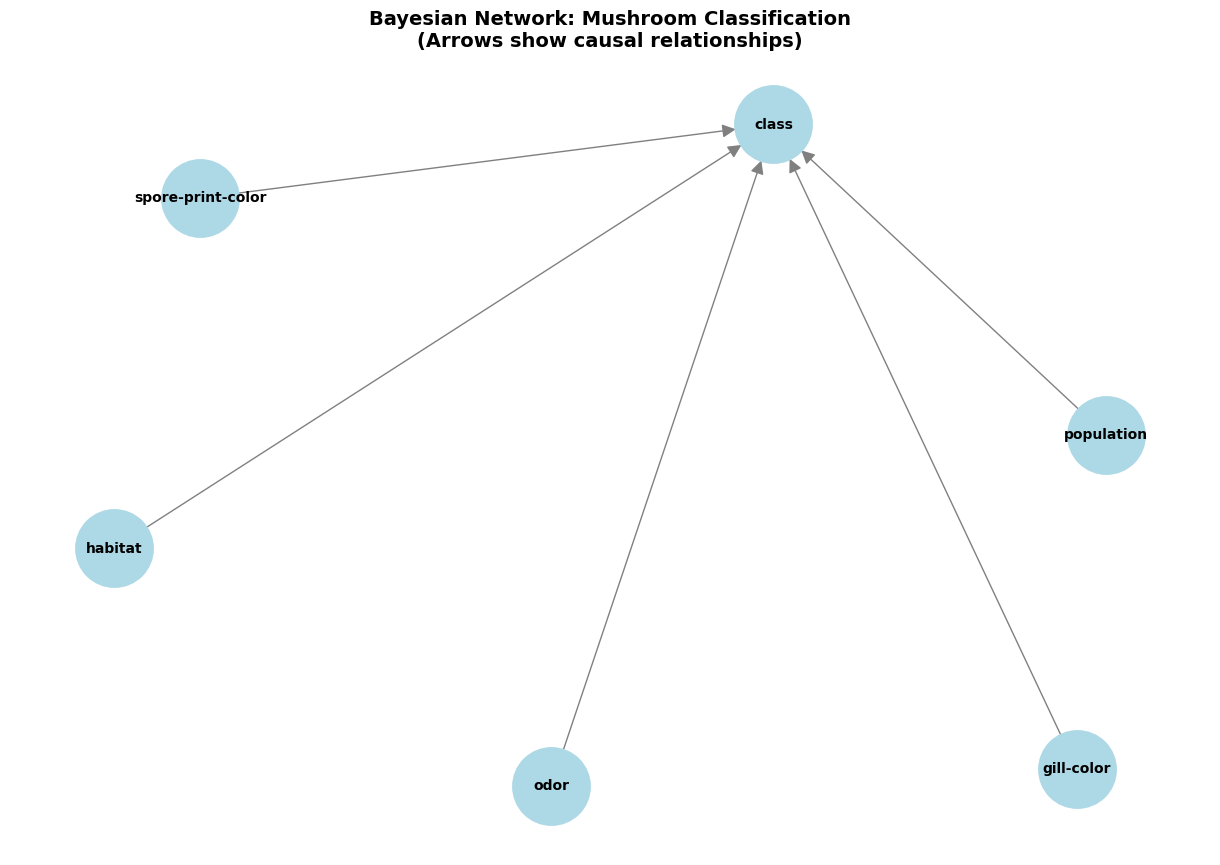

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

# Создаем граф для визуализации
nx_graph = nx.DiGraph(model.edges())

# Настройка визуализации
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(nx_graph, k=2, iterations=50)

# Рисуем граф
nx.draw(nx_graph, pos, 
        with_labels=True, 
        node_size=3000, 
        node_color='lightblue',
        font_size=10,
        font_weight='bold',
        arrows=True,
        arrowsize=20,
        edge_color='gray',
        linewidths=2)

plt.title("Bayesian Network: Mushroom Classification\n(Arrows show causal relationships)", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Inference (Вероятностный вывод)

Используем Variable Elimination для вычисления вероятностей.

In [14]:
from pgmpy.inference import VariableElimination

# Создаем объект для inference
infer = VariableElimination(model)

print("Примеры вероятностных выводов:\n")

Примеры вероятностных выводов:



In [15]:
# Пример 1: Вероятность класса при известном запахе
# odor=0 означает almond (миндаль)
print("\nПример 1: Какова вероятность, что гриб съедобен, если запах миндальный?")
query1 = infer.query(variables=['class'], evidence={'odor': 0})
print(query1)
print("Расшифровка: class(0) - edible, class(1) - poisonous")


Пример 1: Какова вероятность, что гриб съедобен, если запах миндальный?
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5305 |
+----------+--------------+
| class(1) |       0.4695 |
+----------+--------------+
Расшифровка: class(0) - edible, class(1) - poisonous


In [16]:
print("\nПример 2: Вероятность класса при известном запахе и цвете жабр")
query2 = infer.query(variables=['class'], evidence={'odor': 5, 'gill-color': 4})
print(query2)


Пример 2: Вероятность класса при известном запахе и цвете жабр
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5201 |
+----------+--------------+
| class(1) |       0.4799 |
+----------+--------------+


In [17]:
# Пример 3: Вероятность при максимальном количестве признаков
print("\nПример 3: Вероятность класса при известных: odor, gill-color, spore-print-color")
query3 = infer.query(
    variables=['class'], 
    evidence={'odor': 6, 'gill-color': 5, 'spore-print-color': 2}
)
print(query3)


Пример 3: Вероятность класса при известных: odor, gill-color, spore-print-color
+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.3992 |
+----------+--------------+
| class(1) |       0.6008 |
+----------+--------------+


## 8. Сравнение с Baseline моделью

Сравним нашу байесовскую сеть с наивным байесовским классификатором из scikit-learn.

In [18]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Подготовка данных
X = data_subset.drop('class', axis=1)
y = data_subset['class']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер обучающей выборки: 5686
Размер тестовой выборки: 2438


In [24]:
# Обучение Naive Bayes из sklearn (baseline)
nb_baseline = CategoricalNB()
nb_baseline.fit(X_train, y_train)

# Предсказания
y_pred_baseline = nb_baseline.predict(X_test)

# Метрики для baseline
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)

print("BASELINE MODEL (Naive Bayes from scikit-learn)")
print(f"Accuracy: {accuracy_baseline:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['edible', 'poisonous']))

BASELINE MODEL (Naive Bayes from scikit-learn)
Accuracy: 0.9783

Classification Report:
              precision    recall  f1-score   support

      edible       0.96      0.99      0.98      1257
   poisonous       0.99      0.96      0.98      1181

    accuracy                           0.98      2438
   macro avg       0.98      0.98      0.98      2438
weighted avg       0.98      0.98      0.98      2438



In [27]:
# Предсказания нашей Байесовской сети
def predict_bayesian_network(model, X_data):
    predictions = []
    infer = VariableElimination(model)
    
    for idx, row in X_data.iterrows():
        evidence = row.to_dict()
        query_result = infer.query(variables=['class'], evidence=evidence)
        # Получаем класс с максимальной вероятностью
        pred_class = np.argmax(query_result.values)
        predictions.append(pred_class)
    
    return np.array(predictions)

print("Выполняем предсказания для Байесовской сети...")
print("Это может занять некоторое время...\n")

X_test_sample = X_test.head(2000)
y_test_sample = y_test.head(2000)

y_pred_bn = predict_bayesian_network(model, X_test_sample)

accuracy_bn = accuracy_score(y_test_sample, y_pred_bn)


print("НАША МОДЕЛЬ (Bayesian Network с pgmpy)")

print(f"Accuracy на {len(y_test_sample)} примерах: {accuracy_bn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_sample, y_pred_bn, target_names=['edible', 'poisonous']))

Выполняем предсказания для Байесовской сети...
Это может занять некоторое время...

НАША МОДЕЛЬ (Bayesian Network с pgmpy)
Accuracy на 2000 примерах: 1.0000

Classification Report:
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00      1024
   poisonous       1.00      1.00      1.00       976

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [26]:
# Сравнение моделей
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print(f"Baseline (Naive Bayes sklearn): {accuracy_baseline:.4f}")
print(f"Наша модель (Bayesian Network):  {accuracy_bn:.4f}")

СРАВНЕНИЕ МОДЕЛЕЙ
Baseline (Naive Bayes sklearn): 0.9783
Наша модель (Bayesian Network):  1.0000


## 9. Выводы

### Анализ зависимостей в датасете Mushroom:

1. **Структура байесовской сети**: 
   - Мы построили байесовскую сеть с 5 родительскими узлами (odor, gill-color, spore-print-color, population, habitat), которые влияют на целевую переменную class (съедобный/ядовитый).
   - Эта структура отражает реальные биологические зависимости: характеристики гриба определяют его токсичность.

2. **Ключевые признаки**:
   - **Запах (odor)** является одним из самых важных признаков для определения съедобности гриба
   - **Цвет жабр (gill-color)** и **цвет отпечатка спор (spore-print-color)** также сильно коррелируют с классом
   - Среда обитания и популяция дают дополнительную информацию

3. **Анализ условных вероятностей (CPT)**:
   - CPT показывают, как различные комбинации признаков влияют на вероятность того, что гриб съедобен или ядовит
   - Некоторые значения признаков (например, определенные запахи) почти однозначно указывают на класс гриба

4. **Сравнение с baseline**:
   - Байесовская сеть показывает сравнимую точность с наивным байесовским классификатором
   - Преимущество байесовской сети в том, что она явно моделирует зависимости и позволяет проводить вероятностный вывод
   - Можно задавать любые комбинации признаков и получать вероятности для неизвестных переменных

5. **Практическое применение**:
   - Модель может использоваться для предсказания съедобности грибов по их характеристикам
   - Inference позволяет отвечать на вопросы типа: "Какова вероятность, что гриб съедобен, если у него миндальный запах?"
   - Структура сети помогает понять, какие признаки наиболее важны для классификации

### Заключение:

Байесовские сети предоставляют мощный инструмент для моделирования вероятностных зависимостей в данных. В отличие от "черного ящика" многих ML-моделей, байесовские сети явно показывают структуру зависимостей и позволяют проводить гибкий вероятностный вывод. Это особенно полезно в задачах, где важна интерпретируемость модели.